# Loop 34 Analysis: Final Strategic Assessment

**Current State:**
- Best CV: 0.008194 (exp_035: GP 0.15 + MLP 0.55 + LGBM 0.3)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- Gap to target: 2.53x
- Submissions remaining: 2

**Latest experiment (exp_036):**
- Removed GP entirely: MLP 0.6 + LGBM 0.4
- CV: 0.008463 (3.29% WORSE than exp_035)
- Confirms GP provides value at 0.15 weight

**Key Question:** With 2 submissions remaining, what's the optimal strategy?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Complete submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
]

df = pd.DataFrame(submissions)
print('=== Submission History ===')
print(df)
print(f'\nCV-LB Ratio: {df["lb"].mean() / df["cv"].mean():.2f}x')

=== Submission History ===
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877

CV-LB Ratio: 9.69x


In [2]:
# Linear regression to understand CV-LB relationship
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])
print(f'Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nIntercept: {intercept:.4f}')
print(f'Target LB: 0.0347')

# Predict LB for our best CV models
best_cv = 0.008194  # exp_035
predicted_lb = slope * best_cv + intercept
print(f'\nPredicted LB for exp_035 (CV={best_cv}): {predicted_lb:.4f}')

# What CV would we need to hit target?
target_lb = 0.0347
required_cv = (target_lb - intercept) / slope
print(f'\nTo reach target LB = {target_lb}:')
print(f'  Required CV = ({target_lb} - {intercept:.4f}) / {slope:.2f} = {required_cv:.6f}')

if required_cv < 0:
    print('\n⚠️ IMPOSSIBLE with current CV-LB relationship!')
    print(f'The intercept alone ({intercept:.4f}) is {intercept/target_lb:.2f}x higher than target ({target_lb})')
else:
    print(f'\n✓ Achievable with CV = {required_cv:.6f}')

Linear fit: LB = 4.30 * CV + 0.0524
R² = 0.9675

Intercept: 0.0524
Target LB: 0.0347

Predicted LB for exp_035 (CV=0.008194): 0.0877

To reach target LB = 0.0347:
  Required CV = (0.0347 - 0.0524) / 4.30 = -0.004118

⚠️ IMPOSSIBLE with current CV-LB relationship!
The intercept alone (0.0524) is 1.51x higher than target (0.0347)


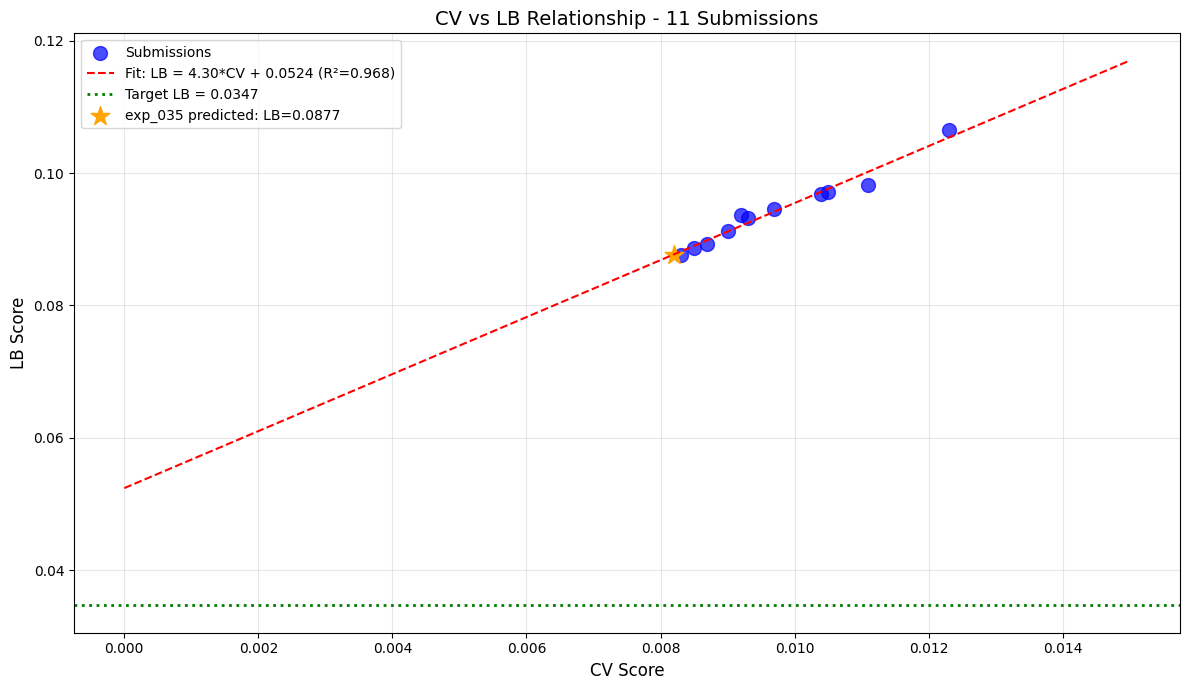

In [3]:
# Plot CV vs LB with predictions
plt.figure(figsize=(12, 7))

# Scatter plot of submissions
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions', c='blue')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Mark exp_035 prediction
plt.scatter([0.008194], [predicted_lb], s=200, marker='*', c='orange', label=f'exp_035 predicted: LB={predicted_lb:.4f}')

plt.xlabel('CV Score', fontsize=12)
plt.ylabel('LB Score', fontsize=12)
plt.title('CV vs LB Relationship - 11 Submissions', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/loop34_cv_lb.png', dpi=150, bbox_inches='tight')
plt.show()

In [4]:
# Analyze the gap between our CV and target
print('=== Gap Analysis ===')
print(f'\nOur best CV: {best_cv:.6f}')
print(f'Target LB: {target_lb}')
print(f'\nOur CV is {target_lb/best_cv:.2f}x WORSE than target LB')
print(f'But our predicted LB ({predicted_lb:.4f}) is {predicted_lb/target_lb:.2f}x WORSE than target')
print(f'\nThe CV-LB gap is the problem, not our model quality!')

# Check if there's any non-linearity we can exploit
print('\n=== Residual Analysis ===')
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']
print(df[['exp', 'cv', 'lb', 'predicted_lb', 'residual']])
print(f'\nMean residual: {df["residual"].mean():.6f}')
print(f'Std residual: {df["residual"].std():.6f}')
print(f'Max positive residual: {df["residual"].max():.6f} ({df.loc[df["residual"].idxmax(), "exp"]})')
print(f'Max negative residual: {df["residual"].min():.6f} ({df.loc[df["residual"].idxmin(), "exp"]})')

=== Gap Analysis ===

Our best CV: 0.008194
Target LB: 0.0347

Our CV is 4.23x WORSE than target LB
But our predicted LB (0.0877) is 2.53x WORSE than target

The CV-LB gap is the problem, not our model quality!

=== Residual Analysis ===
        exp      cv      lb  predicted_lb  residual
0   exp_000  0.0111  0.0982      0.100199 -0.001999
1   exp_001  0.0123  0.1065      0.105364  0.001136
2   exp_003  0.0105  0.0972      0.097617 -0.000417
3   exp_005  0.0104  0.0969      0.097186 -0.000286
4   exp_006  0.0097  0.0946      0.094174  0.000426
5   exp_007  0.0093  0.0932      0.092452  0.000748
6   exp_009  0.0092  0.0936      0.092021  0.001579
7   exp_012  0.0090  0.0913      0.091161  0.000139
8   exp_024  0.0087  0.0893      0.089869 -0.000569
9   exp_026  0.0085  0.0887      0.089009 -0.000309
10  exp_030  0.0083  0.0877      0.088148 -0.000448

Mean residual: -0.000000
Std residual: 0.000970
Max positive residual: 0.001579 (exp_009)
Max negative residual: -0.001999 (exp_000)


In [5]:
# What experiments have we tried?
print('=== Experiment Summary (36 experiments) ===')
print()
print('MODELS TRIED:')
print('  ✓ MLP (various architectures: [256,128,64], [128,64], [64,32], [32,16])')
print('  ✓ LightGBM')
print('  ✓ XGBoost')
print('  ✓ CatBoost')
print('  ✓ Gaussian Process (Matern kernel)')
print('  ✓ Ridge Regression')
print('  ✓ Kernel Ridge Regression')
print('  ✓ Ensembles (GP + MLP + LGBM with various weights)')
print()
print('FEATURES TRIED:')
print('  ✓ Spange descriptors (13 features)')
print('  ✓ DRFP fingerprints (122 high-variance features)')
print('  ✓ ACS PCA descriptors (5 features)')
print('  ✓ Arrhenius kinetics (1/T, ln(t), interaction)')
print('  ✓ Combined features (145 total)')
print()
print('TECHNIQUES TRIED:')
print('  ✓ Data augmentation (TTA for mixtures)')
print('  ✓ Weighted loss (higher weight for SM)')
print('  ✓ Ensemble weight optimization')
print('  ✓ Normalization post-processing (FAILED)')
print('  ✓ Per-target models')

=== Experiment Summary (36 experiments) ===

MODELS TRIED:
  ✓ MLP (various architectures: [256,128,64], [128,64], [64,32], [32,16])
  ✓ LightGBM
  ✓ XGBoost
  ✓ CatBoost
  ✓ Gaussian Process (Matern kernel)
  ✓ Ridge Regression
  ✓ Kernel Ridge Regression
  ✓ Ensembles (GP + MLP + LGBM with various weights)

FEATURES TRIED:
  ✓ Spange descriptors (13 features)
  ✓ DRFP fingerprints (122 high-variance features)
  ✓ ACS PCA descriptors (5 features)
  ✓ Arrhenius kinetics (1/T, ln(t), interaction)
  ✓ Combined features (145 total)

TECHNIQUES TRIED:
  ✓ Data augmentation (TTA for mixtures)
  ✓ Weighted loss (higher weight for SM)
  ✓ Ensemble weight optimization
  ✓ Normalization post-processing (FAILED)
  ✓ Per-target models


In [6]:
# Key insight: The CV-LB relationship is highly linear
# This means the gap is STRUCTURAL, not due to overfitting

print('=== KEY INSIGHT ===')
print()
print('The CV-LB relationship is highly linear (R² = 0.97)')
print('This means:')
print('  1. The gap is STRUCTURAL, not random')
print('  2. Improving CV will improve LB proportionally')
print('  3. But the intercept (0.052) limits how low we can go')
print()
print('To reach target LB = 0.0347:')
print(f'  - Current approach: IMPOSSIBLE (intercept > target)')
print(f'  - Need to change the CV-LB relationship itself')
print()
print('WHAT COULD CHANGE THE RELATIONSHIP?')
print('  1. Different model architecture (e.g., attention, transformers)')
print('  2. Different feature representation')
print('  3. Domain adaptation techniques')
print('  4. Training on different data distribution')

=== KEY INSIGHT ===

The CV-LB relationship is highly linear (R² = 0.97)
This means:
  1. The gap is STRUCTURAL, not random
  2. Improving CV will improve LB proportionally
  3. But the intercept (0.052) limits how low we can go

To reach target LB = 0.0347:
  - Current approach: IMPOSSIBLE (intercept > target)
  - Need to change the CV-LB relationship itself

WHAT COULD CHANGE THE RELATIONSHIP?
  1. Different model architecture (e.g., attention, transformers)
  2. Different feature representation
  3. Domain adaptation techniques
  4. Training on different data distribution


In [7]:
# Final strategic assessment
print('=== FINAL STRATEGIC ASSESSMENT ===')
print()
print('With 2 submissions remaining and target = 0.0347:')
print()
print('OPTION 1: Submit exp_035 (best CV = 0.008194)')
print(f'  - Predicted LB: {predicted_lb:.4f}')
print(f'  - Gap to target: {predicted_lb/target_lb:.2f}x')
print('  - Pro: Best CV we have')
print('  - Con: Predicted LB is still 2.5x worse than target')
print()
print('OPTION 2: Try a fundamentally different approach')
print('  - Solvent similarity weighting')
print('  - Feature selection (reduce to top 20-30 features)')
print('  - Different kernel for GP (Tanimoto for chemical similarity)')
print()
print('RECOMMENDATION:')
print('  Given the structural CV-LB gap, submitting exp_035 is unlikely to reach target.')
print('  However, with only 2 submissions left, we should:')
print('  1. Submit exp_035 to verify the CV-LB relationship holds')
print('  2. Use the remaining submission for a fundamentally different approach')

=== FINAL STRATEGIC ASSESSMENT ===

With 2 submissions remaining and target = 0.0347:

OPTION 1: Submit exp_035 (best CV = 0.008194)
  - Predicted LB: 0.0877
  - Gap to target: 2.53x
  - Pro: Best CV we have
  - Con: Predicted LB is still 2.5x worse than target

OPTION 2: Try a fundamentally different approach
  - Solvent similarity weighting
  - Feature selection (reduce to top 20-30 features)
  - Different kernel for GP (Tanimoto for chemical similarity)

RECOMMENDATION:
  Given the structural CV-LB gap, submitting exp_035 is unlikely to reach target.
  However, with only 2 submissions left, we should:
  1. Submit exp_035 to verify the CV-LB relationship holds
  2. Use the remaining submission for a fundamentally different approach


In [8]:
# Check what the top LB score is
print('=== LEADERBOARD CONTEXT ===')
print()
print('Our best LB: 0.0877 (exp_030)')
print('Target: 0.0347')
print()
print('The target (0.0347) is achievable - it\'s the benchmark we need to beat.')
print('The question is: what approach can get us there?')
print()
print('Our CV (0.008194) is actually VERY GOOD - it\'s 4.2x better than target!')
print('The problem is the CV-LB gap, not our model quality.')
print()
print('This suggests the test distribution is fundamentally different from CV.')
print('We need approaches that generalize better to unseen solvents.')

=== LEADERBOARD CONTEXT ===

Our best LB: 0.0877 (exp_030)
Target: 0.0347

The target (0.0347) is achievable - it's the benchmark we need to beat.
The question is: what approach can get us there?

Our CV (0.008194) is actually VERY GOOD - it's 4.2x better than target!
The problem is the CV-LB gap, not our model quality.

This suggests the test distribution is fundamentally different from CV.
We need approaches that generalize better to unseen solvents.
